# Analyzing Books with Latent Dirichlet Allocation

- [The Brothers Karamazov by Fyodor Dostoyevsky](http://www.gutenberg.org/ebooks/28054)
- https://github.com/JonathanReeve/chapterize
- http://jonreeve.com/2016/08/chapterize/
- [Making sense of XKCD](http://www.merwin.ca/xkcd_writeup/)

In [14]:
%matplotlib inline

In [101]:
import os
import nltk
import gensim
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/cloud-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cloud-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Chapters

In [123]:
folderpath = 'data/28054-0-chapters/'
chapters = []
chapters_texts = []

for chapter_filename in os.listdir(folderpath):
    with open(os.path.join(folderpath, chapter_filename)) as f:
        lines = [line for line in f.readlines() if len(line) > 1]
        line = ' '.join(lines)
        chapters.append(line)
        
df = pd.DataFrame(chapters, columns=['text'])

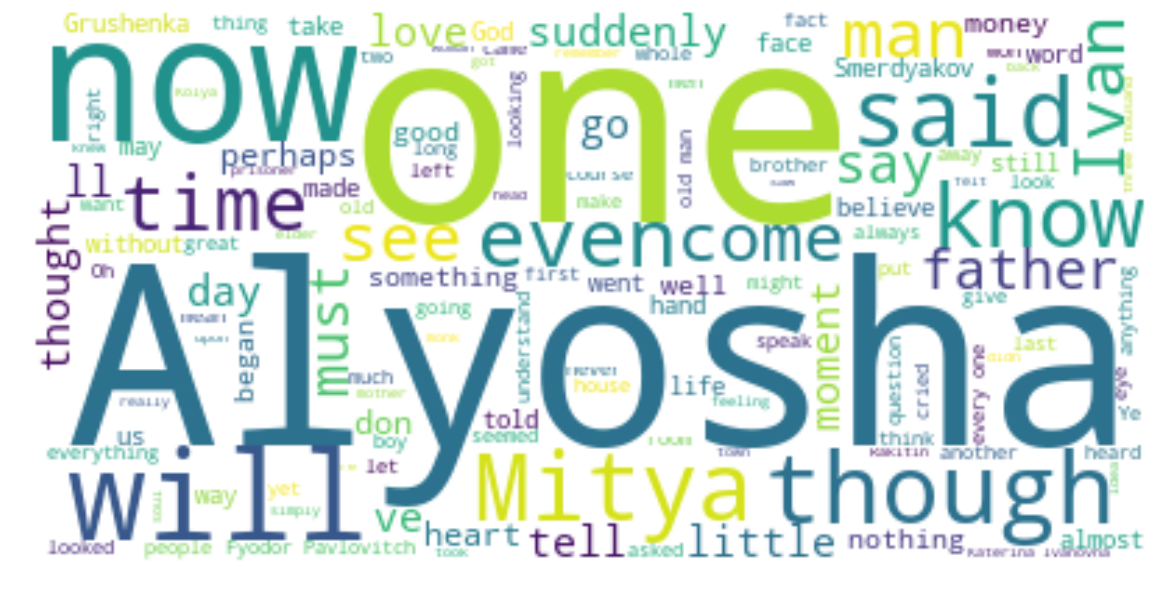

In [124]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate(' '.join(chapters))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

## Preprocess Chapters

In [125]:
# Tokenization
chapters = [nltk.word_tokenize(chapter.lower()) 
            for chapter in chapters]

In [126]:
# Remove special characters
chapters = [[re.sub(r'[^A-Za-z ]+', '', word) for word in chapter] 
            for chapter in chapters]

In [127]:
# Remove unique tokens
frequency = defaultdict(int)
for chapter in chapters:
     for token in chapter:
        frequency[token] += 1
        
chapters = [[token for token in chapter if frequency[token] > 2] 
            for chapter in chapters]

In [128]:
# Remove stop words
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader

stoplist = set(stopwords.words('english'))
chapters = [[word for word in chapter if word not in stoplist] 
            for chapter in chapters]

In [129]:
# Stemming
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
#stemmer = SnowballStemmer("english")
chapters = [[stemmer.stem(word) for word in chapter] 
            for chapter in chapters]

In [130]:
# Remove empty strings
chapters = [[word for word in chapter if word] 
            for chapter in chapters]

## Create corpus and dictionary for LDA

In [131]:
dictionary = gensim.corpora.Dictionary(chapters)
corpus = [dictionary.doc2bow(text) for text in chapters]

In [132]:
# Train model
num_topics= 10
alpha = 0.0001
eta= 0.0001
passes = 10
lda = gensim.models.LdaMulticore(corpus, id2word=dictionary, 
    num_topics=num_topics, alpha=alpha, eta=eta, passes=passes)

## Show top Words of Topics

In [133]:
num_top_words = 5

#show top words of topics
#for t in range(lda.num_topics):
#    print('topic {}: '.format(t) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

#show top words of topics with probabilities  
for t in range(lda.num_topics):
    print('topic {}: '.format(t) + ', '.join([v[0] + " (" + str(v[1]) + ")" 
                                              for v in lda.show_topic(t, num_top_words)]))

topic 0: ivan (0.036208168), smerdyakov (0.034937512), would (0.011126831), look (0.010291509), go (0.009599686)
topic 1: mitya (0.020835584), one (0.010816646), grushenka (0.009627011), come (0.007466085), know (0.0069764443)
topic 2: one (0.011759999), would (0.009570065), man (0.008683925), murder (0.008104012), father (0.0077163437)
topic 3: mitya (0.013308241), one (0.008961505), father (0.0076609724), cri (0.0070588016), look (0.0066049662)
topic 4: kolya (0.013629258), one (0.013420017), boy (0.012673522), know (0.011972848), like (0.009750176)
topic 5: ilusha (0.014144867), kolya (0.012524446), boy (0.010945459), one (0.0101036895), said (0.009786714)
topic 6: one (0.015158369), love (0.014932894), god (0.012560394), mother (0.0119378595), even (0.011560108)
topic 7: thou (0.022932129), man (0.012827806), come (0.010513604), us (0.0104744965), one (0.010355374)
topic 8: alyosha (0.023462374), know (0.013447582), ivan (0.012235981), one (0.010988825), said (0.010664533)
topic 9:

## Visualise Topics and check Relation between them

- [pyLDAvis](https://github.com/bmabey/pyLDAvis) Python library for interactive topic model visualization. Port of the R LDAvis package

In [135]:
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

In [136]:
document_topic_list = list(lda.get_document_topics(corpus))
classified_chapters = [max(document, key=lambda x: x[1]) for document in document_topic_list]
topics              = [top_probability[0] for top_probability in classified_chapters]
probabilites        = [top_probability[1] for top_probability in classified_chapters]
df['topics']        = topics
df['probabilities'] = probabilites

In [139]:
df.loc[df['topics'] == 3].head()

,text,topics,probabilities
14,"Dmitri Fyodorovitch, a young man of eight and ...",3,0.722161
15,"And in the same nervous frenzy, too, he spoke....",3,0.404226
24,But Balaam’s ass had suddenly spoken. The subj...,3,0.887975
51,"So he must drive at full speed, and he had not...",3,0.706394
52,I do not know whether the witnesses for the de...,3,0.539787
